In [66]:
import json
import gzip
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.lines import Line2D
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from scipy import stats

In [67]:
DATA_PATH = "data/"
FIGURE_PATH = "figures/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"

#Source NL https://pageviews.wmcloud.org/?project=nl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Bezorgdheid|Eenzaamheid|Slapeloosheid|Depressie_(klinisch)
#Source IT https://pageviews.wmcloud.org/?project=it.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Stress|Ansia|Disturbo_depressivo|Insonnia|Solitudine
#Source PL https://pageviews.wmcloud.org/?project=pl.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=L%C4%99k|Zaburzenia_depresyjne|Bezsenno%C5%9B%C4%87%7CSamotno%C5%9B%C4%87%7CStres
#Source SV https://pageviews.wmcloud.org/?project=sv.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-01-01&end=2020-08-31&pages=Ångest|Depression|Sömnlöshet|Ensamhet|Stress

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl_2019.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it_2019.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl_2019.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv_2019.csv"



# Q3: What are the differences in effects of lockdowns on mobility in different countries and how do these effects translate to the mental health status of their citizens?

In this part, we will try to answer to answer this question. In order to do that, we will look at the evolution of mental health perception (Stress and loneliness) accross time using COVIDiSTRESS dataset. Then we will look at the pageviews concerning these specific topics during the same period of time as COVIDiSTRESS survey. We will then continue by doing the same with the mobility, using google dataset of mobility. And finally we will look, if there is a correlation between thes 3 effects, if there is one. As explained, in the README, we will conduct this analysis on 4 countries in particular: Italy, the Netherlands, Sweden, and Poland, as they all had different measured applied.

### Covidistress process

In [68]:
#Get the Covidistress data
df_covidistress = pd.read_csv(DATA_PATH + "df_covidistress_clean.csv", low_memory=False)

We can look again at our median distribution for Stress and loneliness perception accross our 4 countries of interest

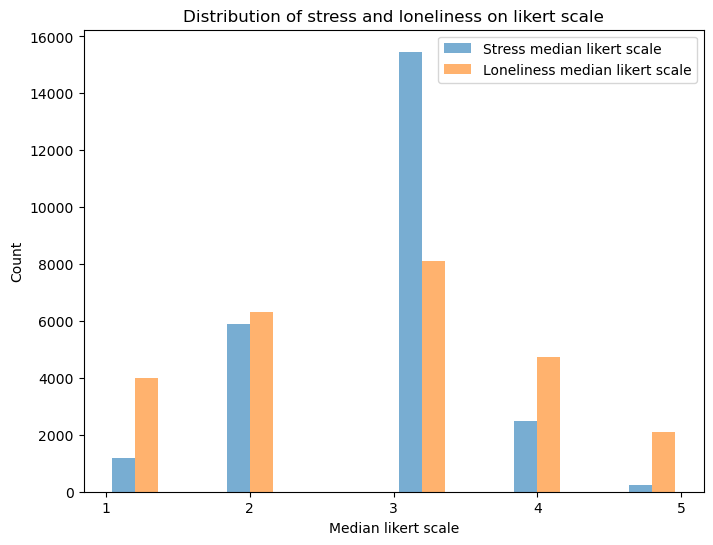

In [69]:
#plot compare distribution of stress and loneliness

plt.figure(figsize=(8,6))
plt.hist([df_covidistress['median_stress'],df_covidistress['median_loneliness']], alpha=0.6, label=['Stress median likert scale', 'Loneliness median likert scale'])
plt.xticks([1,2,3,4,5])
plt.xlabel('Median likert scale')
plt.ylabel('Count')
plt.title('Distribution of stress and loneliness on likert scale')
plt.legend(loc='upper right')
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_stress_loneliness.png')

plt.show()



It seems the overall disribution is quite normal

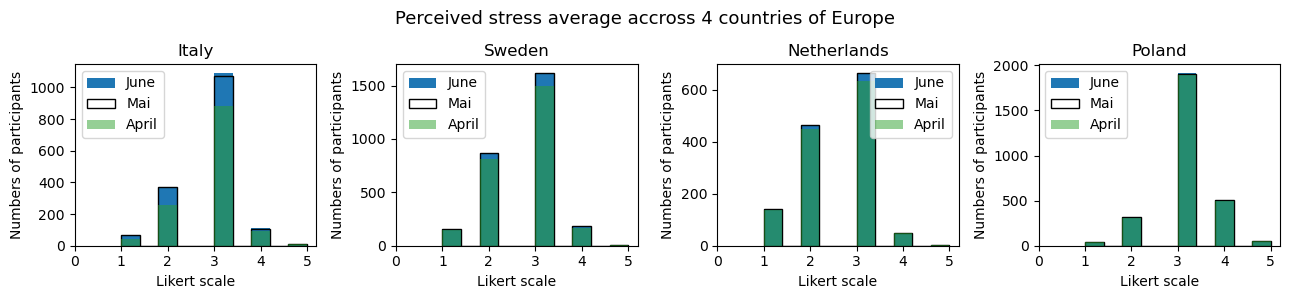

In [70]:
#list of months to choose data set and countries of interests
MONTHS = ['June', 'Mai', 'April']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']

#plot histogramme of the stress median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_covidistress.loc[(df_covidistress['period'] == 'June') & (df_covidistress['Country'] == country)]
    df_hist_mai = df_covidistress.loc[(df_covidistress['period'] == 'Mai') & (df_covidistress['Country'] == country)]
    df_hist_april = df_covidistress.loc[(df_covidistress['period'] == 'April') & (df_covidistress['Country'] == country)]
    axe.hist(df_hist_june['median_stress'][:])
    axe.hist(df_hist_mai['median_stress'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_stress'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_stress_by_country.png')
plt.show()



With a closer look at the median perception of stress in each country, the normalize distribution seems to shift a bit on the left except for Poland 

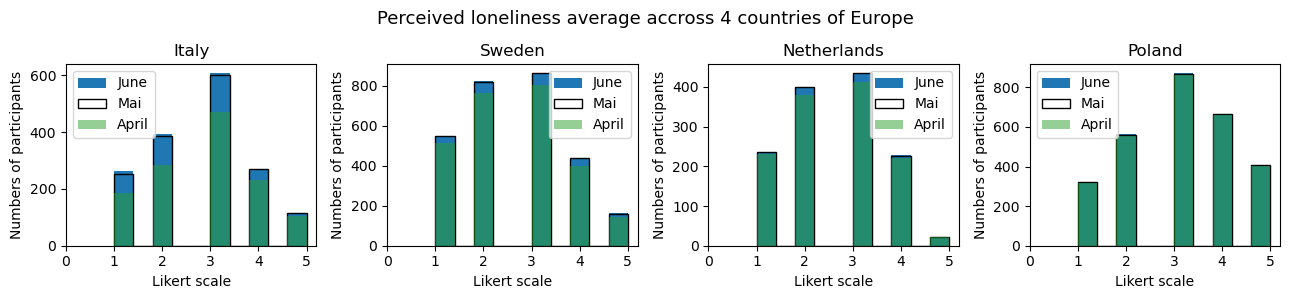

In [71]:
#plot histogramme of the loneliness median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_covidistress.loc[(df_covidistress['period'] == 'June') & (df_covidistress['Country'] == country)]
    df_hist_mai = df_covidistress.loc[(df_covidistress['period'] == 'Mai') & (df_covidistress['Country'] == country)]
    df_hist_april = df_covidistress.loc[(df_covidistress['period'] == 'April') & (df_covidistress['Country'] == country)]
    axe.hist(df_hist_june['median_loneliness'][:])
    axe.hist(df_hist_mai['median_loneliness'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_loneliness'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived loneliness average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
#export to png
plt.savefig(FIGURE_PATH + '\\' +'covidistress_hist_loneliness_by_country.png')
plt.show()



The same goes for loneliness median perception

At first glance, there doesn't seem to have a difference in perceptions between most period in each country. However we have slightly different distribution between country. We will now look at it more in details doing statistical multicomparison test in order to see if there is a difference in time and country.

### Anova testing followed by Conover's Post hoc test.

We do an ANOVA test to look for difference in period and countries and post hoc Conover to see which particular period or country is different if we find statistical results.

In [72]:
alpha_sidak_period = 1 - (1 - 0.05) ** (1 / 3) # Bonferroni correction
print('Sidak correction for period is: ', alpha_sidak_period)
alpha_sidak_country = 1 - (1 - 0.05) ** (1 / 4) # Bonferroni correction
print('Sidak correction for country is: ', alpha_sidak_country)

Sidak correction for period is:  0.016952427508441503
Sidak correction for country is:  0.012741455098566168


### Stress

In [73]:
#anova test for stress perception
df_covidistress.anova(dv='median_stress', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.225377,2.0,0.112688,0.245275,0.782491,0.000019
1,Country,1238.612678,3.0,412.870893,898.646135,0.000000,0.096594
2,period * Country,2.286001,6.0,0.381000,0.829277,0.546951,0.000197
3,Residual,11584.233533,25214.0,0.459437,NaN,NaN,NaN


As we can see here only Country shows significant effect.
Indeed, as seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.

We can now look at the Tukey HSD and conover post hoc test to see which countries differs from the others

In [74]:
sp.posthoc_conover(df_covidistress, val_col='median_stress', group_col='Country', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,4.113532e-96,6.111039e-121,1.133456e-27
Netherlands,4.113532e-96,1.000000e+00,0.000000e+00,5.162962e-38
Poland,6.111039e-121,0.000000e+00,1.000000e+00,0.000000e+00
Sweden,1.133456e-27,5.162962e-38,0.000000e+00,1.000000e+00


We can see here that, all countries are significantly different in terms of stress perception

##### Perceived loneliness

In [75]:
df_covidistress.anova(dv='median_loneliness', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.598883,2.0,0.299441,0.230234,7.943490e-01,0.000018
1,Country,1383.262324,3.0,461.087441,354.520932,1.567319e-225,0.040474
2,period * Country,5.315165,6.0,0.885861,0.681121,6.649423e-01,0.000162
3,Residual,32793.151819,25214.0,1.300593,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Again only country shows sgnificant effect.

Let's check also which countries differ using the posth hoc tests

In [76]:
sp.posthoc_conover(df_covidistress, val_col='median_loneliness', group_col='Country', p_adjust='holm')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,6.592096e-19,3.411188e-48,6.258056e-20
Netherlands,6.592096e-19,1.000000e+00,5.129051e-126,2.042965e-01
Poland,3.411188e-48,5.129051e-126,1.000000e+00,1.039639e-175
Sweden,6.258056e-20,2.042965e-01,1.039639e-175,1.000000e+00


We can see that they all differ between each other except Sweden and Netherlands in terms of perceived loneliness

Unfortunately, we don't find any significant change in time for the perceived mental issues from Covidistress. However, we notice some differences between countries, this may be due to the mobility decisions in each country, which we will explore later on.

## Wiki pageviews process
We will now look at the evolution of pageviews about our 2 mental health of interest accross the 4 countries of interest

In [77]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

In [78]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [79]:
interventions_data.set_index('lang', inplace=True)
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [80]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

apple_mobility_data = apple_mobility_data.drop(columns = ['alternative_name', 'country', 'sub-region'], axis=1)

In [81]:
#function from q2

def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang]
    end = interventions_data['Normalcy'].loc[lang]
    if start == pd.NaT or end == pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['month'] = df['Date'].apply(lambda date: date.month) #add month

    df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'month']]
    return df

def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df

def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region'] == region[lang]]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

def get_dfs(lang, diseases):
    pageviews = get_pageviews_data(lang)
    apple = get_apple_data(lang)
    google = get_google_data(lang)
    df = merge_datasets(pageviews, apple, google)
    return df
        


In [82]:
#get dataframes for each country
df_pv_italy_all = get_dfs('it', diseases_names['en'])
df_pv_netherlands_all = get_dfs('nl', diseases_names['en'])
df_pv_sweden_all = get_dfs('sv', diseases_names['en'])
df_pv_poland_all = get_dfs('pl', diseases_names['en'])

START_CD = pd.to_datetime('2020-03-30')
END_CD = pd.to_datetime('2020-06-17')
#get points from START_CD to END_CD in each country dataframe
df_pv_italy = df_pv_italy_all.loc[START_CD:END_CD]
df_pv_netherlands = df_pv_netherlands_all.loc[START_CD:END_CD]
df_pv_sweden = df_pv_sweden_all.loc[START_CD:END_CD]
df_pv_poland = df_pv_poland_all.loc[START_CD:END_CD]


In [83]:
#Settigns the start and end of each period
START_APRIL = START_CD
END_APRIL = pd.to_datetime('2020-04-27')
START_MAI = pd.to_datetime('2020-04-28')
END_MAI = pd.to_datetime('2020-05-30')
START_JUNE = pd.to_datetime('2020-05-31')
END_JUNE = END_CD

#italy
#add column 'period' to dataframe if index between 30/03/2020 and 27/04/2020, 27/04/2020 and 30/05/2020, 30/05/2020 and 17/06/2020
df_pv_italy.loc[:, 'period'] = 'march' #set default value
df_pv_italy.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_italy.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_italy.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#netherlands
df_pv_netherlands.loc[:,'period'] = 'march' #set default value
df_pv_netherlands.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_netherlands.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_netherlands.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#sweden
df_pv_sweden.loc[:,'period'] = 'march' #set default value
df_pv_sweden.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_sweden.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_sweden.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#poland
df_pv_poland.loc[:,'period'] = 'march' #set default value
df_pv_poland.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_poland.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_poland.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020



C:\Users\josan\AppData\Local\Temp\ipykernel_28684\2248067088.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_italy.loc[:, 'period'] = 'march' #set default value
C:\Users\josan\AppData\Local\Temp\ipykernel_28684\2248067088.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_netherlands.loc[:,'period'] = 'march' #set default value
C:\Users\josan\AppData\Local\Temp\ipykernel_28684\2248067088.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [84]:
#merge all dataframes in one
df_pv = pd.concat([df_pv_italy, df_pv_netherlands, df_pv_sweden, df_pv_poland])
df_pv.head()

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,...,walking,country_region_code,country_region,retail,grocery,parks,stations,workplaces,residential,period
2020-03-30,277,527,555,105,261,Monday,0,0,1,3,...,12.89,IT,Italy,-81.0,-47.0,-79.0,-81.0,-69.0,32.0,april
2020-03-31,260,501,484,135,223,Tuesday,0,0,1,3,...,13.93,IT,Italy,-90.0,-42.0,-78.0,-79.0,-70.0,33.0,april
2020-04-01,250,523,379,130,228,Wednesday,0,0,1,4,...,14.45,IT,Italy,-90.0,-41.0,-77.0,-79.0,-70.0,33.0,april
2020-04-02,290,635,310,91,196,Thursday,0,0,1,4,...,14.92,IT,Italy,-90.0,-40.0,-77.0,-79.0,-70.0,34.0,april
2020-04-03,287,465,270,96,243,Friday,0,0,1,4,...,16.03,IT,Italy,-85.0,-37.0,-78.0,-79.0,-69.0,35.0,april


#### Visualization of pageviews for each countries and mental health during our 3 periods of the survey

In order to understand further our data, lets visualize the pageviews of our mental issues of interest compare to our features of interest: period and country

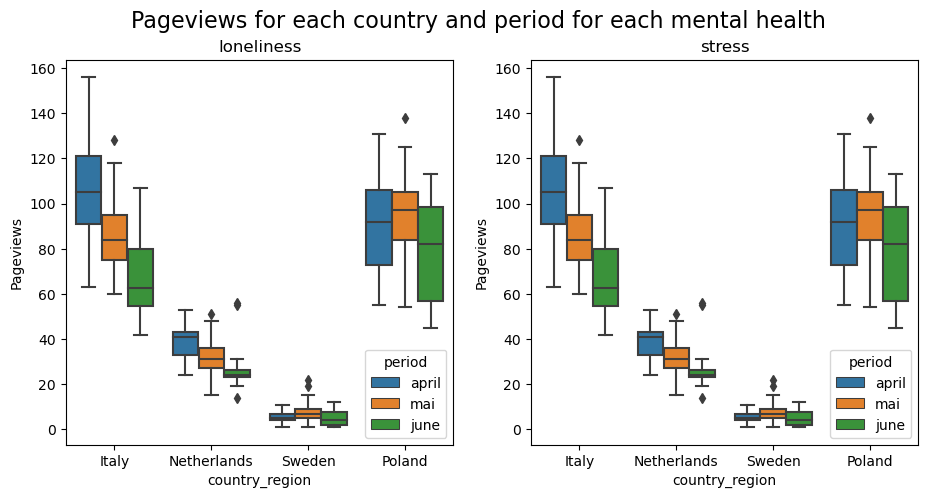

In [85]:
diseases_covidistress = ['loneliness', 'stress']
#plot pageviews for each country and period for each pagename in subplot
fig, ax = plt.subplots(1,2, figsize=(11,5))


for i in range(len(diseases_covidistress)):
    sns.boxplot(x='country_region', y='loneliness', hue='period', data=df_pv, ax=ax[i])
    ax[i].set_title('{}'.format(diseases_covidistress[i]), fontsize=12)
    ax[i].set_ylabel('Pageviews')
fig.suptitle('Pageviews for each country and period for each mental health', fontsize=16)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_pageviews_all.png', dpi=300)
plt.show()




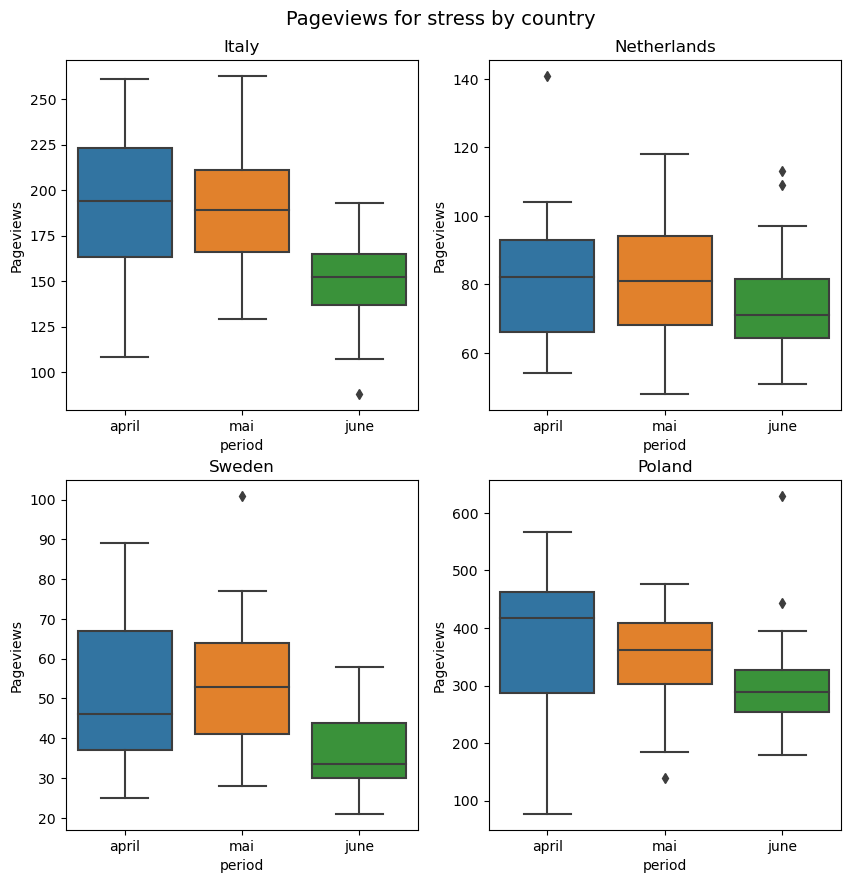

In [86]:
countries_names = ['Italy', 'Netherlands', 'Sweden', 'Poland']

#plot for each countries the pageviews for each mental health and period in subplot
fig, axes = plt.subplots(2,2, figsize = (10,10))
axs = axes.flatten()

for ax, country in zip(axs, countries_names):
    sns.boxplot(x='period', y='stress', data=df_pv.loc[df_pv['country_region'] == country], ax=ax)
    ax.set_title(country)
    ax.set_ylabel('Pageviews')

fig. suptitle('Pageviews for stress by country', fontsize=14, y = 0.93)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_pageviews_stress_by_country.png', dpi=300)
plt.show()



Visually it is hard to see if their is an evolution in stress pageviews accross time. We will need a deeper analysis

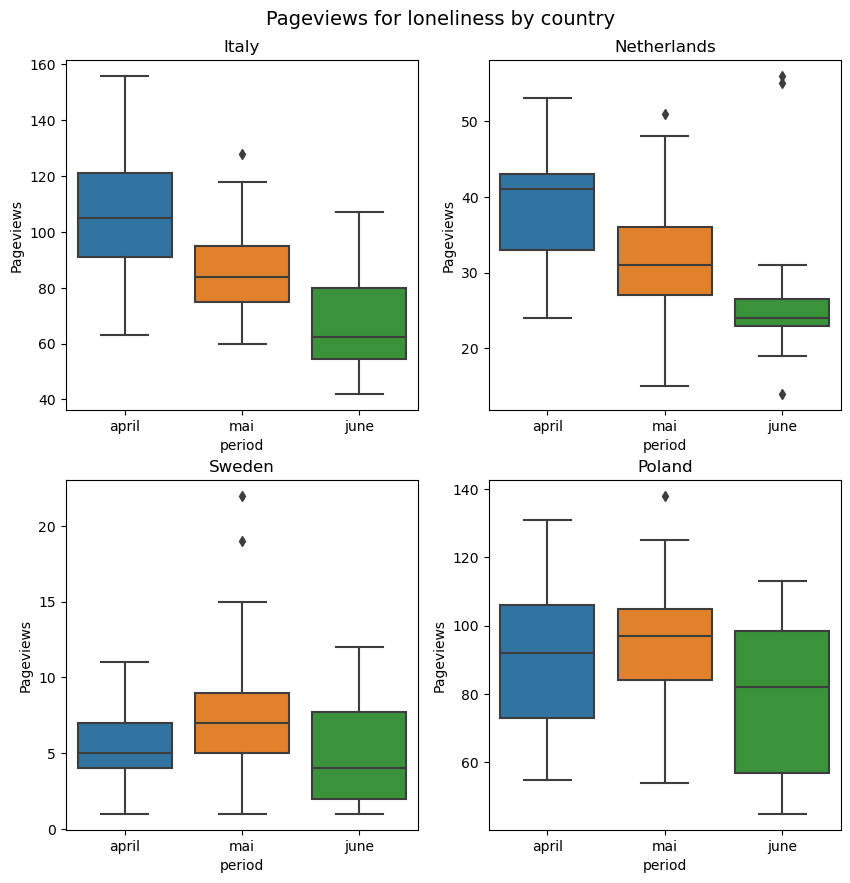

In [87]:

#plot for each countries the pageviews for each mental health and period in subplot
fig, axes = plt.subplots(2,2, figsize = (10,10))
axs = axes.flatten()

for ax, country in zip(axs, countries_names):
    sns.boxplot(x='period', y='loneliness', data=df_pv.loc[df_pv['country_region'] == country], ax=ax)
    ax.set_title(country)
    ax.set_ylabel('Pageviews')

fig. suptitle('Pageviews for loneliness by country', fontsize=14, y = 0.93)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_pageviews_loneliness_by_country.png', dpi=300)
plt.show()



At first glance, their seems to be a decreass of page views in Italy and the Netherlands.

#### ANOVA testing for each disease looking at pageviews variance in relation to periode and country
In order to really see if there is a difference we will do ANOVA test and look for a difference in variance for each groupe.

In [88]:
df_pv.anova(dv='stress', between=['period', 'country_region']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,47119.558,2.0,23559.779,7.237,0.001,0.045
1,country_region,4306549.175,3.0,1435516.392,440.947,0.000,0.811
2,period * country_region,23373.963,6.0,3895.661,1.197,0.308,0.023
3,Residual,1002702.854,308.0,3255.529,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Therefore, all features are significant execpt for period x country

In [89]:
alpha_sidak = 1 - (1 - 0.05) ** (1 / 3)
print(alpha_sidak)

0.016952427508441503


In [90]:
sp.posthoc_conover(df_pv, val_col='stress', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000,0.283786,0.999999
june,0.283786,1.000000,0.258765
mai,0.999999,0.258765,1.000000


Unfortunately, after closer look there doesn't seem to have a significant difference in time either for stress pageviews

In [91]:
sp.posthoc_conover(df_pv, val_col='stress', group_col='country_region', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,1.128476e-46,2.992704e-28,1.072585e-90
Netherlands,1.128476e-46,1.000000e+00,1.679625e-92,2.422485e-26
Poland,2.992704e-28,1.679625e-92,1.000000e+00,3.222736e-129
Sweden,1.072585e-90,2.422485e-26,3.222736e-129,1.000000e+00


Concerning the countries they all differ in terms of pageviews for stress 

#### Anova test and post hoc for loneliness

In [92]:
df_pv.anova(dv='loneliness', between=['period', 'country_region']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,10139.893,2.0,5069.946,23.640,0.0,0.133
1,country_region,416480.059,3.0,138826.686,647.313,0.0,0.863
2,period * country_region,9804.645,6.0,1634.107,7.619,0.0,0.129
3,Residual,66055.575,308.0,214.466,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Hence, we have all significant F

In [93]:
sp.posthoc_conover(df_pv, val_col='loneliness', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000,0.041444,0.835877
june,0.041444,1.000000,0.173314
mai,0.835877,0.173314,1.000000


By looking at the p-values we can see that their is no significant difference in pageview loneliness

In [94]:
sp.posthoc_conover(df_pv, val_col='loneliness', group_col='country_region', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,2.990555e-56,9.593625e-01,9.965409e-105
Netherlands,2.990555e-56,1.000000e+00,2.152623e-59,9.304372e-33
Poland,9.593625e-01,2.152623e-59,1.000000e+00,2.458533e-107
Sweden,9.965409e-105,9.304372e-33,2.458533e-107,1.000000e+00


By looking at the p-values we can also see that their is significant difference in pageview loneliness accross all countries except  Italy-Poland

Like in covidistress perception, we don't seem to find significan't difference in pageview either during the Covidistress survey period. We observe again a difference in country for each mental health pageviews, as seen in the figures. But this might be due to the difference in pageviews at all by languages/countrys

### Mobility

Finally, concerning Covidistress time period, we will look at last at the Apple and Google mobility during this time window.

In [95]:
#getting columns for apple and google mobility data
apple_columns = ['driving', 'transit', 'walking']
google_columns = ['retail', 'grocery', 'parks', 'stations', 'workplaces', 'residential']

#get mean mobility for apple and add a new column
df_pv['mean_apple'] = df_pv[apple_columns].mean(axis=1)
df_pv.head(2)

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,...,country_region_code,country_region,retail,grocery,parks,stations,workplaces,residential,period,mean_apple
2020-03-30,277,527,555,105,261,Monday,0,0,1,3,...,IT,Italy,-81.0,-47.0,-79.0,-81.0,-69.0,32.0,april,13.406667
2020-03-31,260,501,484,135,223,Tuesday,0,0,1,3,...,IT,Italy,-90.0,-42.0,-78.0,-79.0,-70.0,33.0,april,14.180000


In [96]:
#get mean mobility for google and add a new column
df_pv['mean_google'] = df_pv[google_columns].mean(axis=1)
df_pv.head(2)

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,...,country_region,retail,grocery,parks,stations,workplaces,residential,period,mean_apple,mean_google
2020-03-30,277,527,555,105,261,Monday,0,0,1,3,...,Italy,-81.0,-47.0,-79.0,-81.0,-69.0,32.0,april,13.406667,-54.166667
2020-03-31,260,501,484,135,223,Tuesday,0,0,1,3,...,Italy,-90.0,-42.0,-78.0,-79.0,-70.0,33.0,april,14.180000,-54.333333


### Apple mobility
Lets starts with the visualization of the mobility compare to our features of interest.

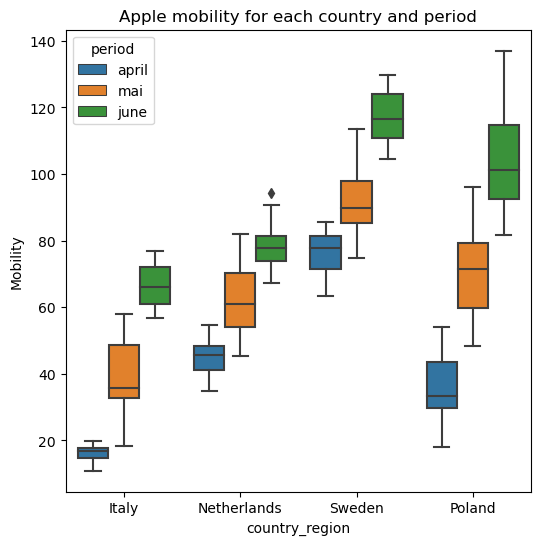

In [97]:
#plot mobility for each country and period for each mental health in subplot
plt.figure(figsize=(6,6))

sns.boxplot(x='country_region', y='mean_apple', hue='period', data=df_pv)
plt.title('Apple mobility for each country and period', fontsize=12)
plt.ylabel('Mobility')
fig.suptitle('Apple mobility for each country and period', fontsize=16)
#export figure to png
plt.savefig(FIGURE_PATH + '\\' + 'Covidistress_mobility_apple_all.png', dpi=300)
plt.show()



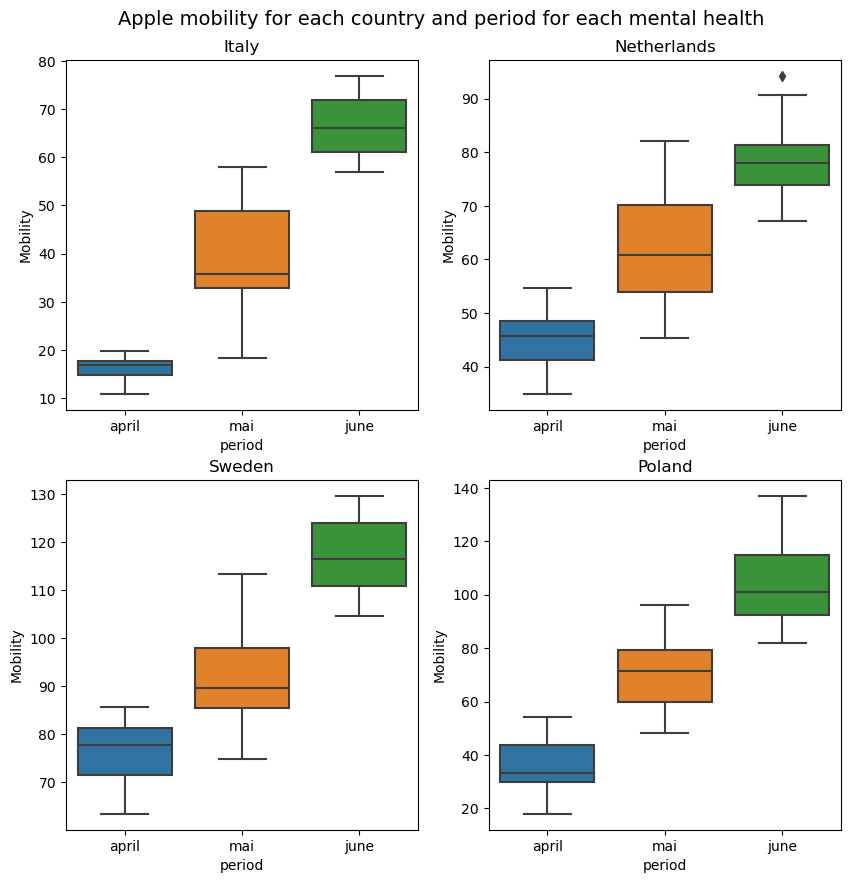

In [98]:
#plot for each countries the apple mobility for each mental health and period in subplot
fig, axes = plt.subplots(2,2, figsize = (10,10))
axs = axes.flatten()

for ax, country in zip(axs, countries_names):
    sns.boxplot(x='period', y='mean_apple', data=df_pv.loc[df_pv['country_region'] == country], ax=ax)
    ax.set_title(country)
    ax.set_ylabel('Mobility')

fig. suptitle('Apple mobility for each country and period for each mental health', fontsize=14, y = 0.93)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_mobility_apple_by_country.png', dpi=300)
plt.show()



It seems at first glance, that there is an increaces in time concerning the mobility for each country.

In [99]:
#anova for apple mobility
df_pv.anova(dv='mean_apple', between=['period', 'country_region']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,105573.786,2.0,52786.893,626.271,0.0,0.807
1,country_region,120302.338,3.0,40100.779,475.761,0.0,0.826
2,period * country_region,8453.264,6.0,1408.877,16.715,0.0,0.251
3,Residual,25286.292,300.0,84.288,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Therefore, all features are significant here.

In [100]:
#posthoc conover on period feature for apple mobility
sp.posthoc_conover(df_pv, val_col='mean_apple', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000e+00,1.212684e-32,2.503420e-13
june,1.212684e-32,1.000000e+00,1.096278e-10
mai,2.503420e-13,1.096278e-10,1.000000e+00


In [101]:
#posthoc conover on country_region feature for apple mobilit
sp.posthoc_conover(df_pv, val_col='mean_apple', group_col='country_region', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,5.802942e-09,2.335092e-13,3.732948e-41
Netherlands,5.802942e-09,1.000000e+00,4.890379e-01,2.888393e-18
Poland,2.335092e-13,4.890379e-01,1.000000e+00,2.904131e-13
Sweden,3.732948e-41,2.888393e-18,2.904131e-13,1.000000e+00


We observe a significant difference between all group in both period and countries. Hence we can conclude that their is indeed an increase in mobility during our survey.

### Google mobility
To confirm this, let's now have a look at google mobility

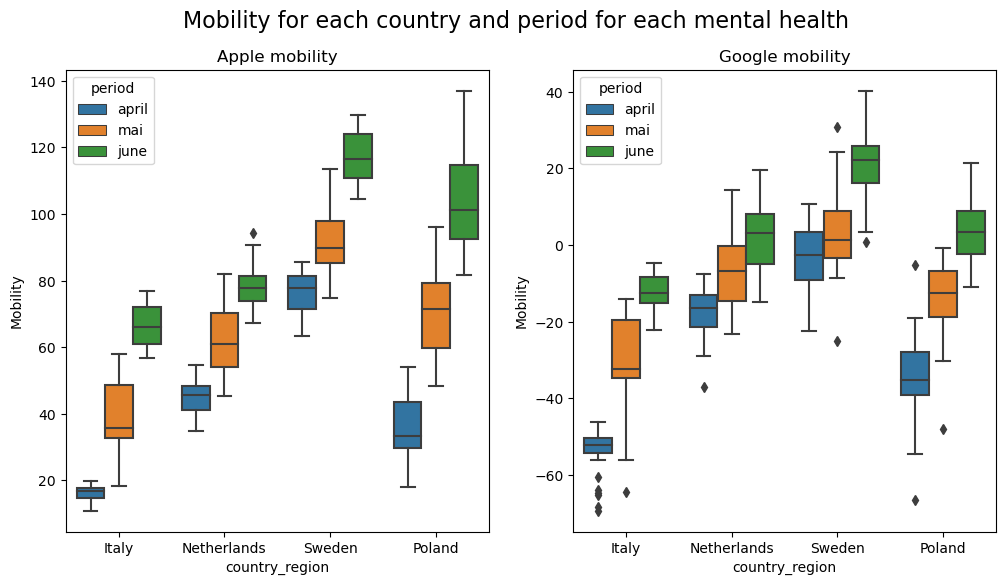

In [102]:
#plot mobility for each country and period for each mental health in subplot
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(x='country_region', y='mean_apple', hue='period', data=df_pv, ax=ax[0])
ax[0].set_title('Apple mobility' , fontsize=12)
ax[0].set_ylabel('Mobility')

sns.boxplot(x='country_region', y='mean_google', hue='period', data=df_pv, ax=ax[1])
ax[1].set_title('Google mobility' , fontsize=12)
ax[1].set_ylabel('Mobility')
fig.suptitle('Mobility for each country and period for each mental health', fontsize=16)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_mobility_all.png', dpi=300)
plt.show()



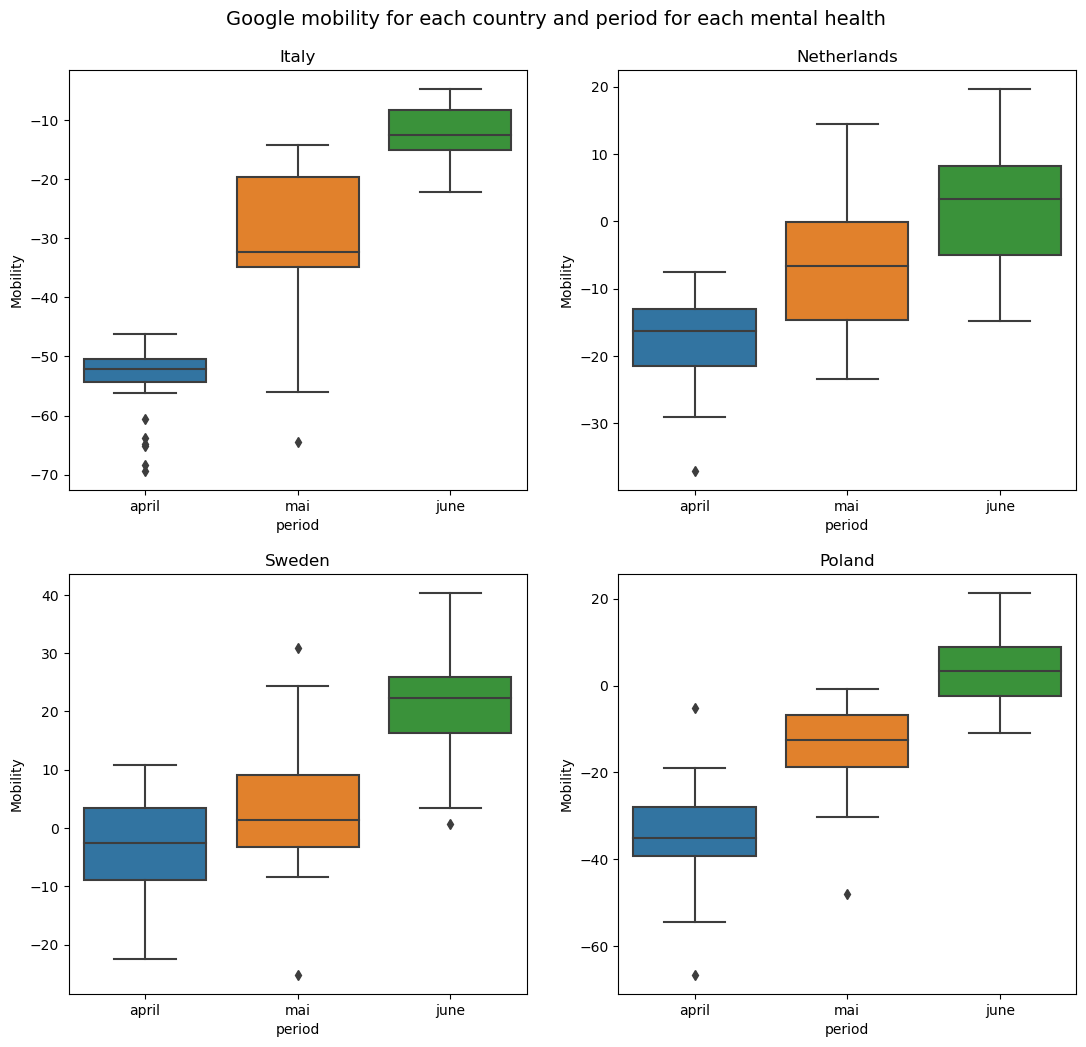

In [103]:
#plot for each countries the google mobility for each mental health and period in subplot
fig, axes = plt.subplots(2,2, figsize = (13,12))
axs = axes.flatten()

for ax, country in zip(axs, countries_names):
    sns.boxplot(x='period', y='mean_google', data=df_pv.loc[df_pv['country_region'] == country], ax=ax)
    ax.set_title(country)
    ax.set_ylabel('Mobility')

fig. suptitle('Google mobility for each country and period for each mental health', fontsize=14, y = 0.93)
#export figure to png
fig.savefig(FIGURE_PATH + '\\' + 'Covidistress_mobility_google_by_country.png', dpi=300)
plt.show()



As in Apple mobility, is looks like that there is an increase in mobility. Lets confirm this with an ANOVA test like for our prior investigation.

In [104]:
#anova for google mobility
df_pv.anova(dv='mean_google', between=['period', 'country_region']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,44624.120,2.0,22312.060,244.005,0.0,0.613
1,country_region,69504.334,3.0,23168.111,253.367,0.0,0.712
2,period * country_region,4771.357,6.0,795.226,8.697,0.0,0.145
3,Residual,28163.811,308.0,91.441,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Therefore, all features are significant here.

In [105]:
#posthoc conover on period feature for google mobility
sp.posthoc_conover(df_pv, val_col='mean_google', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000e+00,7.329557e-25,8.169531e-09
june,7.329557e-25,1.000000e+00,2.647308e-09
mai,8.169531e-09,2.647308e-09,1.000000e+00


In [106]:
#posthoc conover on country feature for google mobility
sp.posthoc_conover(df_pv, val_col='mean_google', group_col='country_region', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,8.718257e-20,1.497779e-09,4.505061e-44
Netherlands,8.718257e-20,1.000000e+00,3.950914e-03,1.044145e-09
Poland,1.497779e-09,3.950914e-03,1.000000e+00,5.456217e-20
Sweden,4.505061e-44,1.044145e-09,5.456217e-20,1.000000e+00


All our p-values are significant, hence as in Apple mobility, Google mobility shows also an significant increase in mobility during Covidistress survey time period.

We now see an increases in mobility in all countries in both Apple and Google mobility datasets. This coincide with the dates of relaxed mesures for each countries: [20 April for Poland](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Poland), [May 6 for Netherlands](https://www.containmentnu.nl/articles/timeline?lang=en), [May 18th for Italy](https://en.wikipedia.org/wiki/COVID-19_lockdowns_in_Italy) and [April 1st for Sweden](https://sweden.se/life/society/sweden-and-corona-in-brief).

## Checking correlation

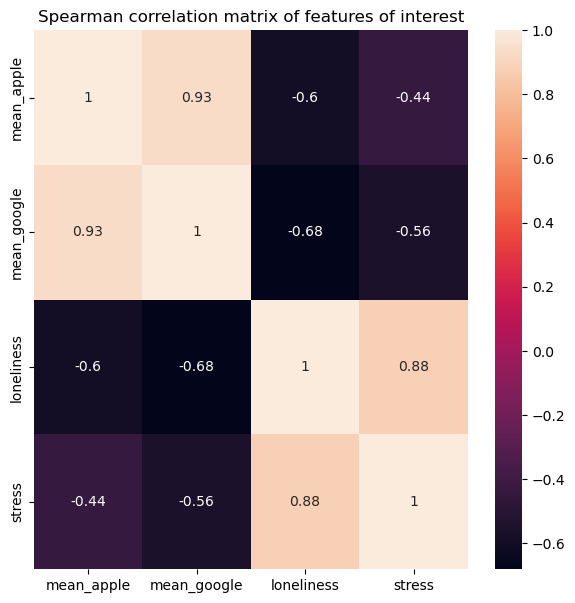

In [107]:
features_columns = ['mean_apple', 'mean_google', 'loneliness', 'stress', 'country_region', 'period']
#correlation matrix for features of interest
corr_matrix_features = df_pv[features_columns].corr(method='spearman').round(2)
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix_features, annot=True)
plt.title('Spearman correlation matrix of features of interest')
#export figure to png
plt.savefig(FIGURE_PATH + '\\' + 'Covidistress_correlation_matrix_features.png', dpi=300)
plt.show()



We can see that Stress and Loneliness pageviews are indeed negatively correlated with mobility as seen in the precedent questions.

## Conclusion Question 3

Concerning the answer to our question about the true perceived stress and loneliness, unfortunately the data we obtain from Covidistress survey doesn't have significant value and cannot help us determinate the perception of loneliness and stress during the first part of Covid-19. We are unable to observe a change of perception. However, we can still see that in general the people from our countries of interest (i.e Italy, Netherland, Poland and Sweden), are still mildly inflicted by loneliness and Stress, as we can see that they have a median of 3 in the likert-scale.

We still see a positive change in mobility, which coincide with the relaxed restriction of thoses countries. 